In [1]:
import torch
import io
import torch.nn.functional as F
import random
import numpy as np
import time
import math
import datetime
import torch.nn as nn
from transformers import *
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import matplotlib.pyplot as plt

seed_val = 213
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

c:\Users\Paolo\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# If there's a GPU available...
#if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
#    device = torch.device("cuda")
#    print('There are %d GPU(s) available.' % torch.cuda.device_count())
#    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
#else:
#    print('No GPU available, using the CPU instead.')
device = torch.device("cpu")

In [3]:
import csv

def load_dataset_examples(input_file, skip_first_row):
  """Creates examples for the training and dev sets for the sentipolc dataset."""
  examples = []
  labels = []

  with open(input_file, "r", encoding="utf8") as infile:
   reader = csv.reader(infile, delimiter='\1')
   if skip_first_row:
      next(reader, None)  # skip the headers
   for row in reader:
      text = row[2]
      label = row[3]
      labels.append(label)
      examples.append((text, label))

  return examples, set(labels)

In [4]:
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_csv("C:/Users/Paolo/OneDrive - Universita' degli Studi di Roma Tor Vergata/Laurea Magistrale/Tesi/Codice/2.Classificazione/Dummy/Data/data_dummy_cleaned_for_nn.csv", sep='___', engine='python')

training_data, testing_data = train_test_split(df, test_size=0.3)


tsv = training_data.to_csv(sep='\1', index=False) # use '\1' if your data contains tabs
#psv = tsv.replace('\1', '___')
with open("C:/Users/Paolo/OneDrive - Universita' degli Studi di Roma Tor Vergata/Laurea Magistrale/Tesi/Codice/2.Classificazione/Dummy/Data/news_train.csv", 'w', encoding='utf-8', newline='\n') as outfile:
    outfile.write(tsv)

tsv1 = testing_data.to_csv(sep='\1', index=False) # use '\1' if your data contains tabs
#psv1 = tsv1.replace('\1', '___')
with open("C:/Users/Paolo/OneDrive - Universita' degli Studi di Roma Tor Vergata/Laurea Magistrale/Tesi/Codice/2.Classificazione/Dummy/Data/news_test.csv", 'w', encoding='utf-8', newline='\n') as outfile:
    outfile.write(tsv1)

train = "C:/Users/Paolo/OneDrive - Universita' degli Studi di Roma Tor Vergata/Laurea Magistrale/Tesi/Codice/2.Classificazione/Dummy/Data/news_train.csv"
test = "C:/Users/Paolo/OneDrive - Universita' degli Studi di Roma Tor Vergata/Laurea Magistrale/Tesi/Codice/2.Classificazione/Dummy/Data/news_test.csv"
train_examples, train_labels = load_dataset_examples(train, skip_first_row=True)
test_examples, test_labels = load_dataset_examples(test, skip_first_row=True)



In [5]:
print("Some training examples:\n")

for i in range(1, 10):
  print(train_examples[i])

Some training examples:

('By KIRO 7 News Staff August 04, 2022 at 2:57 pm PDT In a few weeks, students in western Washington will be heading back to the classroom. It comes as we deal with the most contagious COVID-19 variant we’ve seen to date, leaving many parents wondering when is the best time to vaccinate or boost their children against the virus.', 'Treatment')
('Republican candidate for governor Darren Bailey upped his class warfare attack on Democratic Gov. JB Pritzker with a new video Thursday in which the wealthy downstate farmer contends the billionaire first-term governor has “soft hands” and “never worked a day” in his life.  “JB Pritzker, you were born with a silver spoon in your mouth.', 'Health-Effects')
('The Ottawa Redblacks could be catching the Calgary Stampeders at an opportune time. Ottawa (1-6-0) is coming off its first win of the season heading into Friday’s game against the Stampeders at TD Place Stadium. Calgary, meanwhile, is dealing with its first losing st

In [6]:
# This is a multi-class classification task. 
label_list = list(train_labels.union(test_labels))
label_list.sort()
# Let us print the labels used in the dataset
print("Target Labels:\t" + str(label_list))
print("Number of Labels:\t" + str(len(label_list)))

Target Labels:	['Coronavirus', 'ET_SPORTFR', 'GeneralEconomicKeywords', 'Health-Effects', 'Treatment']
Number of Labels:	5


In [7]:
#--------------------------------------------
#  English models
# --------------------------------------------
#model_name = "bert-base-cased"
#model_name = "bert-base-uncased"
#model_name = "bert-large-cased"
#model_name = "bert-large-uncased"
#model_name = "bert-large-uncased-whole-word-masking"

#model_name = "roberta-base"
#model_name = "roberta-large"

#model_name = "albert-base-v2"
#model_name = "albert-large-v2"
#model_name = "albert-xlarge-v2"

#model_name = "google/electra-base-discriminator"

#model_name = "distilbert-base-cased"
#model_name = "distilbert-base-uncased"

# --------------------------------------------
#  Multilingual models
# --------------------------------------------
model_name = "bert-base-multilingual-cased" #the uncased should not be used
#model_name = "xlm-roberta-base"

# --------------------------------------------
#  Italian models (my language) 
# --------------------------------------------
#model_name = "m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0"
#model_name = "Musixmatch/umberto-commoncrawl-cased-v1"

# Notice that a lot of models pre-trained for specific languages are available
# at https://huggingface.co/models

In [8]:
class Classifier(nn.Module):
    def __init__(self, model_name, num_labels=2, dropout_rate=0.1):
      super(Classifier, self).__init__()
      # Load the BERT-based encoder
      self.encoder = AutoModel.from_pretrained(model_name)
      # The AutoConfig allows to access the encoder configuration. 
      # The configuration is needed to derive the size of the embedding, which 
      # is produced by BERT (and similar models) to encode the input elements. 
      config = AutoConfig.from_pretrained(model_name)
      self.cls_size = int(config.hidden_size)
      # Dropout is applied before the final classifier
      self.input_dropout = nn.Dropout(p=dropout_rate)
      # Final linear classifier
      self.fully_connected_layer = nn.Linear(self.cls_size,num_labels)

    def forward(self, input_ids, attention_mask):
      # encode all outputs
      model_outputs = self.encoder(input_ids, attention_mask)
      # just select the vector associated to the [CLS] symbol used as
      # first token for ALL sentences
      encoded_cls = model_outputs.last_hidden_state[:,0]
      # apply dropout
      encoded_cls_dp = self.input_dropout(encoded_cls)
      # apply the linear classifier
      logits = self.fully_connected_layer(encoded_cls_dp)
      # return the logits
      return logits, encoded_cls

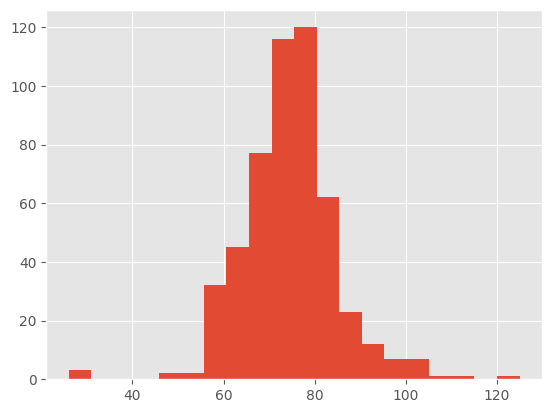

In [9]:
# Define a Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

#Print the length distribution
plt.style.use("ggplot")
plt.hist([len(tokenizer.encode_plus(text)["input_ids"]) for text, label in train_examples], bins=20)
plt.show()

In [10]:
# --------------------------------
# Encoder (i.e., BERT) parameters
# --------------------------------

# the maximum length to be considered in input
max_seq_length = 64
# dropout applied to the embedding produced by BERT before the classifiation
out_dropout_rate = 0.1

# --------------------------------
# Training parameters
# --------------------------------

# Dev percentage split, i.e., the percentage of training material to be use for
# evaluating the model during training
dev_perc = 0.1

# the batch size
batch_size = 64

# the learning rate used during the training process
learning_rate = 2e-5 
# if you use large models (such as Bert-large) it is a good idea to use 
# smaller values, such as 5e-6

# name of the fine_tuned_model
output_model_name = "best_model.pickle"

# number of training epochs
num_train_epochs = 5

# ADVANCED: Schedulers allow to define dynamic learning rates.
# You can find all available schedulers here
# https://huggingface.co/transformers/main_classes/optimizer_schedules.html
apply_scheduler = False
# Here a `Constant schedule with warmup`can be activated. More details here
# https://huggingface.co/transformers/main_classes/optimizer_schedules.html#transformers.get_constant_schedule_with_warmup
warmup_proportion = 0.1

# --------------------------------
# Log parameters
# --------------------------------

# Print a log each n steps
print_each_n_step = 10

In [11]:
def generate_data_loader(examples, label_map, tokenizer, do_shuffle = False):
  '''
  Generate a Dataloader given the input examples

  examples: a list of pairs (input_text, label)
  label_mal: a dictionary used to assign an ID to each label
  tokenize: the tokenizer used to convert input sentences into word pieces
  do_shuffle: a boolean parameter to shuffle input examples (usefull in training) 
  ''' 
  #-----------------------------------------------
  # Generate input examples to the Transformer
  #-----------------------------------------------
  input_ids = []
  input_mask_array = []
  label_id_array = []

  # Tokenization 
  for (text, label) in examples:
    # tokenizer.encode_plus is a crucial method which:
    # 1. tokenizes examples
    # 2. trims sequences to a max_seq_length
    # 3. applies a pad to shorter sequences
    # 4. assigns the [CLS] special wor-piece such as the other ones (e.g., [SEP])
    encoded_sent = tokenizer.encode_plus(text, add_special_tokens=True, max_length=max_seq_length, padding='max_length', truncation=True)
    # convert input word pieces to IDs of the corresponding input embeddings
    input_ids.append(encoded_sent['input_ids'])
    # store the attention mask to avoid computations over "padded" elements
    input_mask_array.append(encoded_sent['attention_mask'])
  
    # converts labels to IDs
    id = -1
    if label in label_map:
      id = label_map[label]
    label_id_array.append(id)
       
  # Convert to Tensor which are used in PyTorch
  input_ids = torch.tensor(input_ids) 
  input_mask_array = torch.tensor(input_mask_array)
  label_id_array = torch.tensor(label_id_array, dtype=torch.long)
  
  # Building the TensorDataset
  dataset = TensorDataset(input_ids, input_mask_array, label_id_array)

  if do_shuffle:
    # this will shuffle examples each time a new batch is required
    sampler = RandomSampler
  else:
    sampler = SequentialSampler

  # Building the DataLoader
  return DataLoader(
              dataset,  # The training samples.
              sampler = sampler(dataset), # the adopted sampler
              batch_size = batch_size) # Trains with this batch size.

In [12]:
# Initialize a map to associate labels to the dimension of the embedding 
# produced by the classifier
label_to_id_map = {}
id_to_label_map = {}
for (i, label) in enumerate(label_list):
  label_to_id_map[label] = i
  id_to_label_map[i] = label

# Shuffle and split the training material in train/dev
random.shuffle(train_examples)
train_subset_examples = train_examples[int(len(train_examples) * 0) : int(len(train_examples) * (1-dev_perc))]
dev_subset_examples = train_examples[int(len(train_examples) * (1-dev_perc)) : int(len(train_examples))]

# Build the Train Dataloader
train_dataloader = generate_data_loader(train_subset_examples, label_to_id_map, tokenizer, do_shuffle = True)
# Build the Development Dataloader
dev_dataloader = generate_data_loader(dev_subset_examples, label_to_id_map, tokenizer, do_shuffle = True)
# Build the Test DataLoader
test_dataloader = generate_data_loader(test_examples, label_to_id_map, tokenizer, do_shuffle = False)

print("Number of training examples:\t"+ str(len(train_subset_examples)))
print("Number of development examples:\t"+ str(len(dev_subset_examples)))
print("Number of test examples:\t"+ str(len(test_examples)))

Number of training examples:	459
Number of development examples:	52
Number of test examples:	220


In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import sys


def evaluate(dataloader, classifier, print_classification_output=False, print_result_summary=False):

  '''
  Evaluation method which will be applied to development and test datasets.
  It returns the pair (average loss, accuracy)
  
  dataloader: a dataloader containing examples to be classified
  classifier: the BERT-based classifier
  print_classification_output: to log the classification outcomes 
  ''' 
  total_loss = 0
  gold_classes = [] 
  system_classes = []
 
  if print_classification_output:
      print("\n------------------------")
      print("  Classification outcomes")
      print("is_correct\tgold_label\tsystem_label\ttext")
      print("------------------------")

  # For each batch of examples from the input dataloader
  for batch in dataloader:   
    # Unpack this training batch from our dataloader. Notice this is populated 
    # in the method `generate_data_loader`
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():
      # Each batch is classifed        
      logits, _ = classifier(b_input_ids, b_input_mask)
      # Evaluate the loss. 
      total_loss += nll_loss(logits, b_labels)
        
    # Accumulate the predictions and the input labels
    _, preds = torch.max(logits, 1)
    system_classes += preds.detach().cpu()
    gold_classes += b_labels.detach().cpu()

    # Print the output of the classification for each input element
    if print_classification_output:
      for ex_id in range(len(b_input_mask)):
        input_strings = tokenizer.decode(b_input_ids[ex_id], skip_special_tokens=True)
        # convert class id to the real label
        predicted_label = id_to_label_map[preds[ex_id].item()]
        gold_standard_label = "UNKNOWN"
        # convert the gold standard class ID into a real label
        if b_labels[ex_id].item() in id_to_label_map:
          gold_standard_label = id_to_label_map[b_labels[ex_id].item()]
        # put the prefix "[OK]" if the classification is correct
        output = '[OK]' if predicted_label == gold_standard_label else '[NO]'
        # print the output
        print(output+"\t"+gold_standard_label+"\t"+predicted_label+"\t"+input_strings)

  # Calculate the average loss over all of the batches.
  avg_loss = total_loss / len(dataloader)
  avg_loss = avg_loss.item()

  # Report the final accuracy for this validation run.
  system_classes = torch.stack(system_classes).numpy()
  gold_classes = torch.stack(gold_classes).numpy()
  accuracy = np.sum(system_classes == gold_classes) / len(system_classes)

  if print_result_summary:
    print("\n------------------------")
    print("  Summary")
    print("------------------------")
    #remove unused classes in the test material
    filtered_label_list = []
    for i in range(len(label_list)):
      if i in gold_classes:
        filtered_label_list.append(id_to_label_map[i])
    print(classification_report(gold_classes, system_classes, digits=3, target_names=filtered_label_list))

    print("\n------------------------")
    print("  Confusion Matrix")
    print("------------------------")
    conf_mat = confusion_matrix(gold_classes, system_classes)
    for row_id in range(len(conf_mat)):
      print(filtered_label_list[row_id]+"\t"+str(conf_mat[row_id]))
         
  return avg_loss, accuracy

In [16]:
classifier = Classifier(model_name, num_labels=len(label_list), dropout_rate=out_dropout_rate)

# Put everything in the GPU if available
#if torch.cuda.is_available():    
  #classifier.cuda()

# Define the Optimizer. Here the ADAM optimizer (a sort of standard de-facto) is
# used. AdamW is a variant which also adopts Weigth Decay.
optimizer = torch.optim.AdamW(classifier.parameters(), lr=learning_rate)
# More details about the Optimizers can be found here:
# https://huggingface.co/transformers/main_classes/optimizer_schedules.html

# Define the scheduler
if apply_scheduler:
  # Estimate the numbers of step corresponding to the warmup.
  num_train_examples = len(train_examples)
  num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
  num_warmup_steps = int(num_train_steps * warmup_proportion)
  # Initialize the scheduler
  scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps = num_warmup_steps)

In [15]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)


In [49]:
training_stats = []


# Define the LOSS function. A CrossEntropyLoss is used for multi-class 
# classification tasks. 
nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)
# All loss functions are available at:
# - https://pytorch.org/docs/stable/nn.html#loss-functions

# Measure the total training time for the whole run.
total_t0 = time.time()

# NOTICE: the measure to be maximized should depends on the task. 
# Here accuracy is used.
best_dev_accuracy = -1

# For each epoch...
for epoch_i in range(0, num_train_epochs):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    train_loss = 0

    # Put the model into training mode.
    classifier.train() 

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every print_each_n_step batches.
        if step % print_each_n_step == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        train_logits, _ = classifier(b_input_ids, b_input_mask)
        # calculate the loss        
        loss = nll_loss(train_logits, b_labels)      
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward() 
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()
    
        # Update the learning rate with the scheduler, if specified
        if apply_scheduler:
          scheduler.step()
    
    # Calculate the average loss over all of the batches.
    avg_train_loss = train_loss / len(train_dataloader)
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.3f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #     Evaluate on the Development set
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our test set.
    print("")
    print("Running Test...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    classifier.eval()

    # Apply the evaluate_method defined above to estimate 
    avg_dev_loss, dev_accuracy = evaluate(test_dataloader, classifier)

    # Measure how long the validation run took.
    test_time = format_time(time.time() - t0)

    print("  Accuracy: {0:.3f}".format(dev_accuracy))
    print("  Test Loss: {0:.3f}".format(avg_dev_loss))
    print("  Test took: {:}".format(test_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_dev_loss,
            'Valid. Accur.': dev_accuracy,
            'Training Time': training_time,
            'Test Time': test_time
        }
    )

    # Save the model if the performance on the development set increases
    if dev_accuracy > best_dev_accuracy:
      best_dev_accuracy = dev_accuracy
      torch.save(classifier, output_model_name)
      print("\n  Saving the model during epoch " + str(epoch_i))
      print("  Actual Best Validation Accuracy: {0:.3f}".format(best_dev_accuracy))


======== Epoch 1 / 5 ========
Training...

  Average training loss: 1.507
  Training epcoh took: 0:01:01

Running Test...
  Accuracy: 0.427
  Test Loss: 1.353
  Test took: 0:00:09

  Saving the model during epoch 0
  Actual Best Validation Accuracy: 0.427

======== Epoch 2 / 5 ========
Training...

  Average training loss: 1.119
  Training epcoh took: 0:01:00

Running Test...
  Accuracy: 0.555
  Test Loss: 1.114
  Test took: 0:00:09

  Saving the model during epoch 1
  Actual Best Validation Accuracy: 0.555

======== Epoch 3 / 5 ========
Training...

  Average training loss: 0.915
  Training epcoh took: 0:00:59

Running Test...
  Accuracy: 0.668
  Test Loss: 0.894
  Test took: 0:00:09

  Saving the model during epoch 2
  Actual Best Validation Accuracy: 0.668

======== Epoch 4 / 5 ========
Training...

  Average training loss: 0.616
  Training epcoh took: 0:01:00

Running Test...
  Accuracy: 0.673
  Test Loss: 0.855
  Test took: 0:00:09

  Saving the model during epoch 3
  Actual Best

{'epoch': 1, 'Training Loss': 1.506857916712761, 'Valid. Loss': 1.3530113697052002, 'Valid. Accur.': 0.42727272727272725, 'Training Time': '0:01:01', 'Test Time': '0:00:09'}
{'epoch': 2, 'Training Loss': 1.1188564598560333, 'Valid. Loss': 1.1141057014465332, 'Valid. Accur.': 0.5545454545454546, 'Training Time': '0:01:00', 'Test Time': '0:00:09'}
{'epoch': 3, 'Training Loss': 0.91534673422575, 'Valid. Loss': 0.8943408727645874, 'Valid. Accur.': 0.6681818181818182, 'Training Time': '0:00:59', 'Test Time': '0:00:09'}
{'epoch': 4, 'Training Loss': 0.6155253797769547, 'Valid. Loss': 0.8554961681365967, 'Valid. Accur.': 0.6727272727272727, 'Training Time': '0:01:00', 'Test Time': '0:00:09'}
{'epoch': 5, 'Training Loss': 0.47816716879606247, 'Valid. Loss': 0.9197219014167786, 'Valid. Accur.': 0.6727272727272727, 'Training Time': '0:00:59', 'Test Time': '0:00:09'}


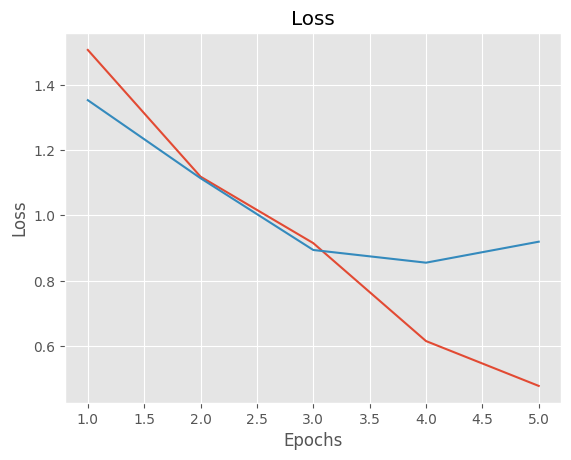

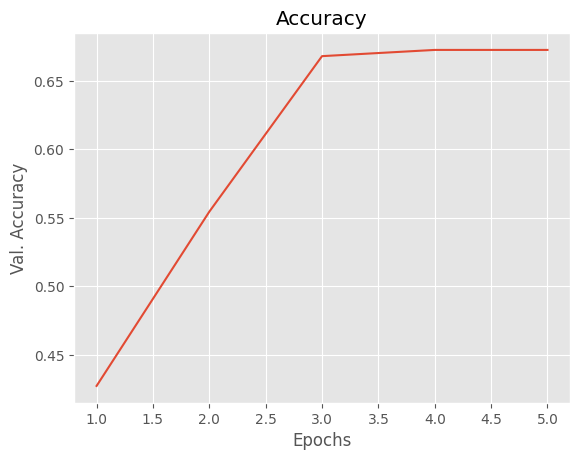


Training complete!
Total training took 0:05:47 (h:mm:ss)


In [50]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []

for stat in training_stats:
  train_losses.append(stat["Training Loss"])
  val_losses.append(stat["Valid. Loss"])
  val_acc.append(stat["Valid. Accur."])
  print(stat)

plt.plot(range(1,num_train_epochs+1), train_losses, label = "Training Loss")
plt.plot(range(1,num_train_epochs+1), val_losses, label = "Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.plot(range(1,num_train_epochs+1), val_acc, label = "Val Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Val. Accuracy")
plt.show()

print("\nTraining complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [51]:
# Load the best model
best_model = torch.load(output_model_name)
torch.save(best_model, 'C:/Users/Paolo/Documents/state_dict_model.pt')

# Evaluate it
avg_test_loss, test_accuracy = evaluate(test_dataloader, best_model, print_classification_output = True, print_result_summary=True)

print("\n\n  Accuracy: {0:.3f}".format(test_accuracy))
print("  Test Loss: {0:.3f}".format(avg_test_loss))


------------------------
  Classification outcomes
is_correct	gold_label	system_label	text
------------------------
[OK]	Health-Effects	Health-Effects	- GlobeNewsWire - Nasdaq ) ST. LOUIS, Aug. 04, 2022 ( GLOBE NEWSWIRE ) - - BellRing Brands, Inc. ( NYSE : BRBR ) ( BellRing ), a holding company
[OK]	Health-Effects	Health-Effects	Second Quarter 2022 Results Second quarter net loss of $ 87. 9 million or $ 3. 32 per diluted share, down from a net loss of $ 4. 0 million or $ 0. 14 per diluted share in the prior year quarter, with the reduction stemming from a net $ 90. 8
[NO]	GeneralEconomicKeywords	Health-Effects	Performance Shipping Inc., a global shipping company specializing in the ownership of tanker vessels, today reported net income from continuing and discontinued operations of $ 3. 9 million and net income from continuing and discontinued operations attributable to common stockholders of $ 3.
[OK]	ET_SPORTFR	ET_SPORTFR	Novak Djokovic withdrew from the upcoming hard - court tourna

In [52]:
# Let us select a simple example
my_test = "rifiuta di fare il vaccino"
label = "_"

# Let us convert it in a pair that can be used to populate a dataloader...
my_list = [(my_test,label)]
my_data_loader = generate_data_loader(my_list, label_to_id_map, tokenizer)

# ... and reuse the evaluate method
_, _ = evaluate(my_data_loader, best_model, print_classification_output = True)


------------------------
  Classification outcomes
is_correct	gold_label	system_label	text
------------------------
[NO]	UNKNOWN	Treatment	rifiuta di fare il vaccino


In [13]:
my_model = torch.load("C:/Users/Paolo/OneDrive - Universita' degli Studi di Roma Tor Vergata/Laurea Magistrale/Tesi/Codice/2.Classificazione/Dummy/state_dict_model.pt")
my_model.eval()

Classifier(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [18]:
# Let us select a simple example
my_test = "Le società Atlante Eurobasket Roma e Givova Scafati annunciano il rinvio del match di campionato fra i due team, valido per il recupero del 15esimo turno della Serie A2 2021/22, previsto originariamente per questo mercoledi.  Il rinvio è stato disposto dal Settore Agonistico della FIP a seguito dei numerosi casi di positività al Covid-19 all’interno del Gruppo Squadra della squadra campana."
label = "_"

# Let us convert it in a pair that can be used to populate a dataloader...
my_list = [(my_test,label)]
my_data_loader = generate_data_loader(my_list, label_to_id_map, tokenizer)

# ... and reuse the evaluate method
_, _ = evaluate(my_data_loader, my_model, print_classification_output = True)


------------------------
  Classification outcomes
is_correct	gold_label	system_label	text
------------------------
[NO]	UNKNOWN	ET_SPORTFR	Le società Atlante Eurobasket Roma e Givova Scafati annunciano il rinvio del match di campionato fra i due team, valido per il recupero del 15esimo turno della Serie A2 2021 / 22, previsto originariamente per questo mercoledi. Il rinvio è stato
